In [1]:
%autoreload 2

In [107]:
from collections import defaultdict, Counter
from itertools import combinations, chain
import json
from types import SimpleNamespace
import typing


import colorcet as cc
import krippendorff
from IPython.display import display, HTML, Markdown
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate


In [3]:
class ExtendedSimpleNamespace(SimpleNamespace):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __contains__(self, key):
        return hasattr(self, key)

    def __getitem__(self, key):
        return getattr(self, key)

    def get(self, key, default=None):
        return getattr(self, key, default)

    def keys(self):
        return [k for k in vars(self).keys() if not k.startswith("_")]
        

In [4]:
PREVIOUS_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_40_data.json'
CURRENT_DATA_PATH = './human_evals_data/real-complete_only-main-pilot_01-27_data.json'

GAME_KEYS = [
    'id', 'real', 'matched', 
    'confident', 'fun_play', 'fun_watch', 
    'capability', 'goldilocks', 'creativity',
    'human-likeness', 'explain', 'overall'
]

RENAMED_GAME_KEYS = {
    'id': 'game_id',
    'human-likeness': 'human_likeness'
}

NUMBER_SCORE_ATTRIBUTES = [
    'confident', 'fun_play', 
    'fun_watch',  'capability', 
    'goldilocks', 'creativity',
    'human_likeness',
]

NUMBER_SCORE_AXIS_NAMES = {
    'confident': 'How confident are you that you understand the game?',
    'fun_play': 'How fun would it be to play the game yourself?',
    'fun_watch': 'How fun would it be to watch someone else play the game?',
    'capability': 'How helpful would it be for learning to interact',
    'goldilocks': 'Too easy, appropriately difficult, or too hard for you?',
    'creativity': 'How creatively designed is the game?',
    'human_likeness': 'How human-like do you think this game is?',
}


def load_data(data_path: str) -> typing.Tuple[typing.List[ExtendedSimpleNamespace], typing.List[ExtendedSimpleNamespace]]:
    with open(data_path, 'r') as f:
        raw_data = json.load(f, object_hook=lambda d: ExtendedSimpleNamespace(**d))

    prolific_participants_data = []
    non_prolific_participants_data = []

    for participant_data in raw_data:
        if participant_data.data.recruitment_info.get('prolific_id', ''):
            prolific_participants_data.append(participant_data)
        else:
            non_prolific_participants_data.append(participant_data)

    return prolific_participants_data, non_prolific_participants_data


def real_matched_to_str(series: pd.Series) -> str:
    if series.real:
        return 'real'

    if series.matched:
        return 'matched'

    return 'unmatched'


def full_game_id_to_str(series: pd.Series) -> str:
    return f"{series.game_id}-{series.game_type}"


def loaded_data_to_df(loaded_data: typing.List[ExtendedSimpleNamespace]):
    rows = []

    for participant in loaded_data:
        participant_id = participant.id
        prolific_id = participant.data.recruitment_info.prolific_id

        for game_result in participant.data.single_game_results:
            rows.append({
                'participant_id': participant_id,
                'prolific_id': prolific_id,
                **{RENAMED_GAME_KEYS.get(key, key): game_result[key] for key in GAME_KEYS}
            })
    
    df = pd.DataFrame(rows)
    df = df.assign(game_type=pd.Categorical(df.apply(real_matched_to_str, axis=1), categories=['real', 'matched', 'unmatched'], ordered=True))
    df = df.assign(full_game_id=df.apply(full_game_id_to_str, axis=1))
    
    return df


def load_data_to_df(data_path: str, prolific_only: bool = True):
    prolific_participants_data, non_prolific_participants_data = load_data(data_path)
    if not prolific_only:
        prolific_participants_data.extend(non_prolific_participants_data)

    return prolific_participants_data, loaded_data_to_df(prolific_participants_data)


current_participants_raw_data, current_participants_df = load_data_to_df(CURRENT_DATA_PATH)
previous_participants_raw_data, previous_participants_df = load_data_to_df(PREVIOUS_DATA_PATH)
print(f'Loaded current participant data with shape {current_participants_df.shape} from {CURRENT_DATA_PATH}')
print(f'Loaded previous participant data with shape {previous_participants_df.shape} from {PREVIOUS_DATA_PATH}')

new_prolific_participant_ids = set(current_participants_df.prolific_id) - set(previous_participants_df.prolific_id)
print(f"{len(new_prolific_participant_ids)} new prolific participants:")
for prolific_id in sorted(new_prolific_participant_ids):
    print(f"\t{prolific_id}")

print(f'Dataframe shape: {current_participants_df.shape}')
current_participants_df.head()


Loaded current participant data with shape (489, 16) from ./human_evals_data/real-complete_only-main-pilot_01-27_data.json
Loaded previous participant data with shape (370, 16) from ./human_evals_data/real-complete_only-main-pilot_40_data.json
12 new prolific participants:
	5769a352f48c3b00016737f9
	5c1c74700036a80001193c24
	5cfb459229a6c2001764e10d
	5d350282cec7150015d16494
	5d453e8723a5bb0001492546
	5e5e623737be5e1762ad4418
	5eeaa8ee94a7f8046a02a20d
	60fdd725b2cd02db32f9c718
	6168d40137ffaa2e184d02da
	63614899ad49a91f1ef09067
	6564a4689e58a4504f5ee238
	656f18a4879aba85a3134f00
Dataframe shape: (489, 16)


,participant_id,prolific_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,4,3,3,5,3,2,2,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched"
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,4,3,3,4,3,3,2,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched"
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,4,2,2,5,4,3,2,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,5,4,4,3,2,2,2,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched"
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,1,1,1,1,5,1,3,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched"


In [5]:
current_participants_df.game_id

0      (1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)
1      (1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)
2      (1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)
3      (1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)
4      (1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)
                       ...                 
484    (1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
485    (1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0)
486    (1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)
487    (1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0)
488    (1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Name: game_id, Length: 489, dtype: object

In [6]:
[p.data.debrief_responses.comments for p in current_participants_raw_data]

['I wasn\'t sure how to answer the question regarding how "human-like" the game seems. The games were all virtual.',
 'This was very underpaid with all the writing and the number of games. ',
 'no',
 'N/A',
 'You guys kinda catfished us, as far as the Writing Requirements for this assignment goes.',
 'No',
 'Thank you for the opportunity.',
 "I don't think I would actually want to play any of these games",
 '',
 'no',
 'none.',
 'No. Thank you!',
 '',
 'I enjoyed the experiment. ',
 'no thank you for the opportunity',
 'Nothing that I can think of. Thank you and good luck on your project. ',
 'thank you',
 'No',
 'This was pretty interesting! Thanks for the opportunity to contribute.',
 'no',
 'None.',
 "Nothing to add but it would be nice if there was a progress bar while we're evaluating these games as it nearly killed me trying to get through the last 2 evaluations with no end in sight.",
 'I used the text entry box to type out certain notes as I worked the idea through my mind, but

In [7]:
def add_linebreaks(string: str, n_lines: int = 2, min_break_length: int = 36):
    if len(string) <= min_break_length:
        return string

    prev_break_index = 0
    line_parts = []

    for break_index in range(1, n_lines):
        break_index = string.find(' ', int(break_index * len(string) / n_lines))
        if break_index == -1:
            break

        line_parts.append(string[prev_break_index:break_index])
        prev_break_index = break_index + 1

    line_parts.append(string[prev_break_index:])
    return '\n'.join(line_parts)


## Per-participant spread on each question

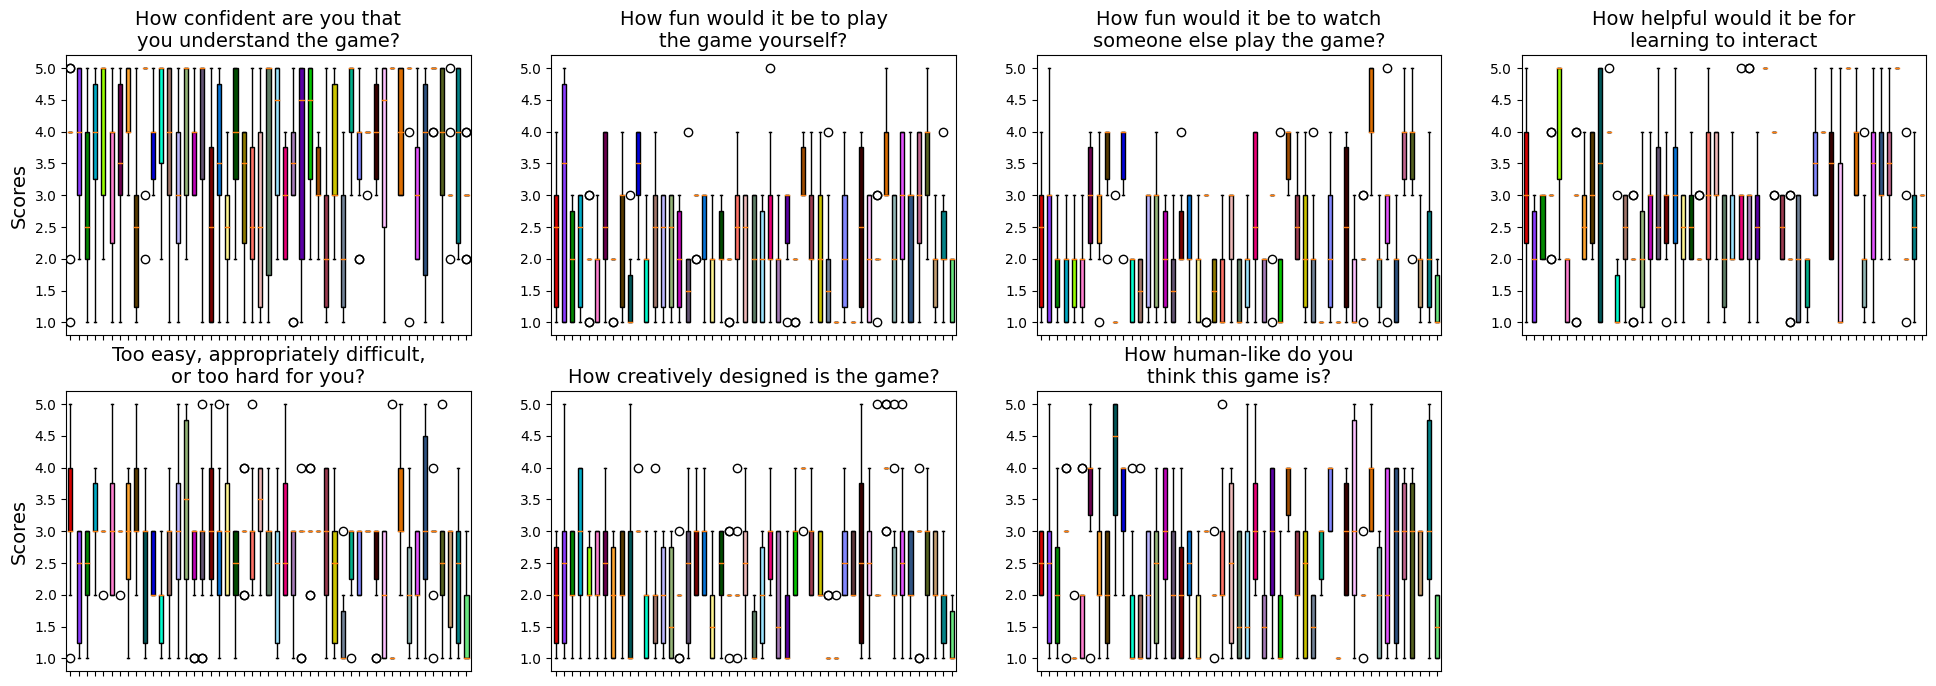

In [8]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 7
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
cmap = cc.cm.glasbey

grouped = current_participants_df.groupby('prolific_id')
participant_ids = list(current_participants_df.prolific_id.unique())
data_by_participant_id = {pid: {} for pid in participant_ids}

for i, (name, group) in enumerate(grouped):
    for attribute in NUMBER_SCORE_ATTRIBUTES:
        data_by_participant_id[name][attribute] = group[attribute].values


for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    data = [data_by_participant_id[pid][attribute] for pid in participant_ids]
    positions = np.arange(len(data))
    bp = ax.boxplot(data, positions=positions, patch_artist=True)

    # Loop over each boxplot and set the color
    for b, box in enumerate(bp['boxes']):
        box.set_facecolor(cmap(b))

    ax.set_xticklabels([''] * len(participant_ids))
    if i % NCOLS == 0:
        ax.set_ylabel('Scores', fontdict=FONTDICT)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)

    if i >= START_XLABELS_INDEX:
        ax.set_xticks(np.arange(len(participant_ids)))
        ax.set_xticklabels(participant_ids, rotation=90)
        ax.set_xlabel('prolific_id', fontdict=FONTDICT)

# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()

## Per-game type bar plot on each questiion

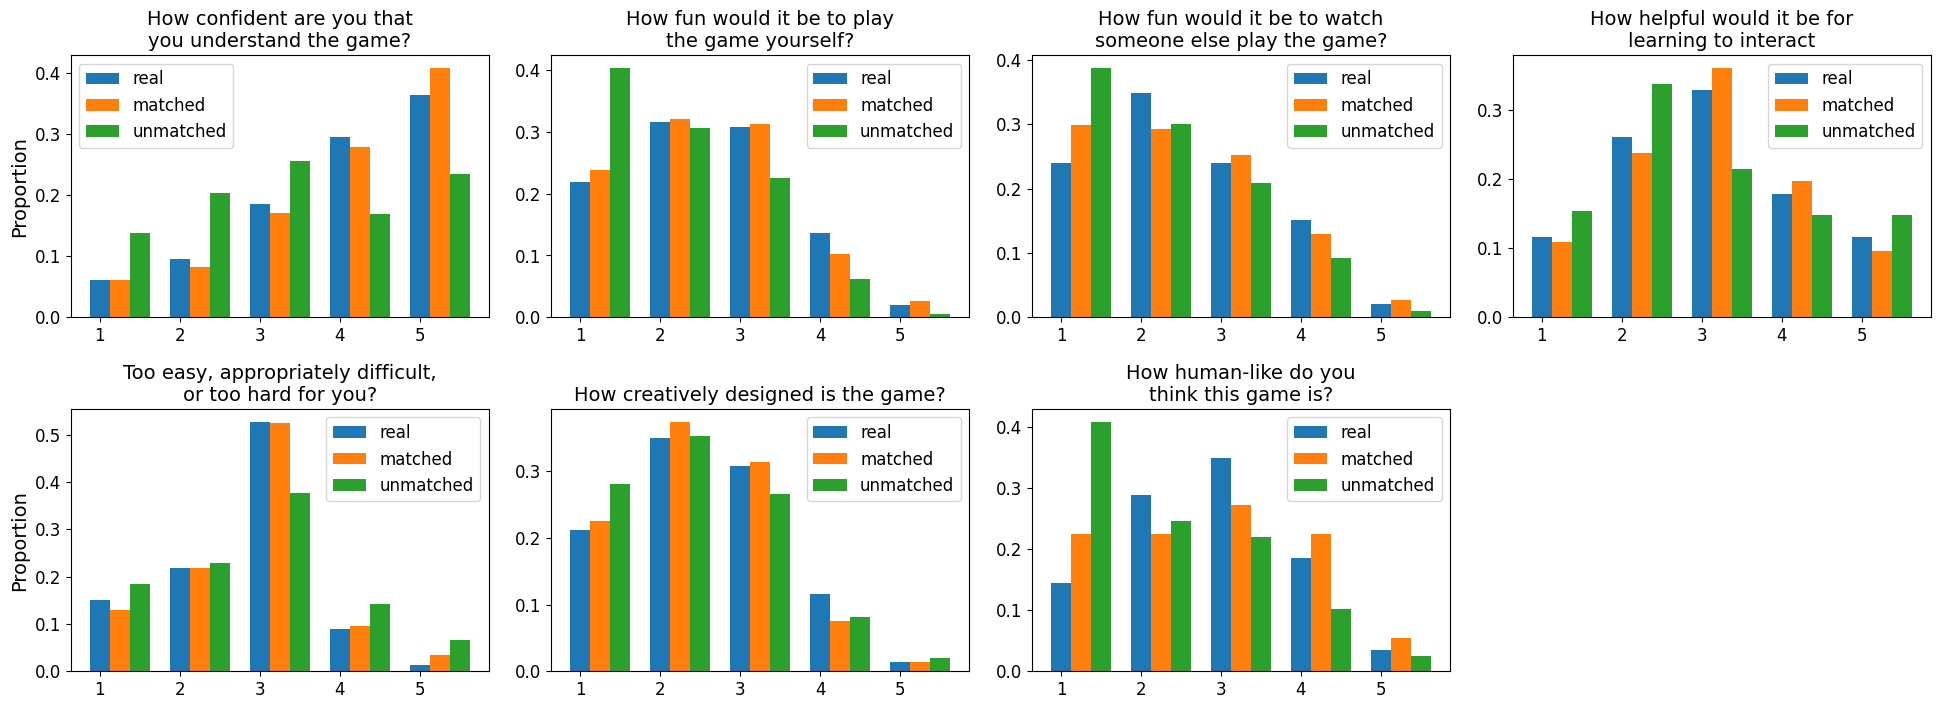

In [9]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
SEPARATE_PLOTS = False


if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))

game_type_groupby = current_participants_df.groupby('game_type')
game_type_value_counts = current_participants_df.game_type.value_counts()

x = np.arange(5) + 1
width = 0.25
multiplier = 0

for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    multiplier = 0
    for game_type in current_participants_df.game_type.cat.categories:
        offset = width * multiplier
        normalized_value_counts = game_type_groupby.get_group(game_type)[attribute].value_counts().sort_index() / game_type_value_counts[game_type]
        ax.bar(x + offset, normalized_value_counts, width=width, label=game_type)
        multiplier += 1

    ax.set_xlabel('')

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)

    if SEPARATE_PLOTS:
        plt.show()

if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


## Matched game difference comparison

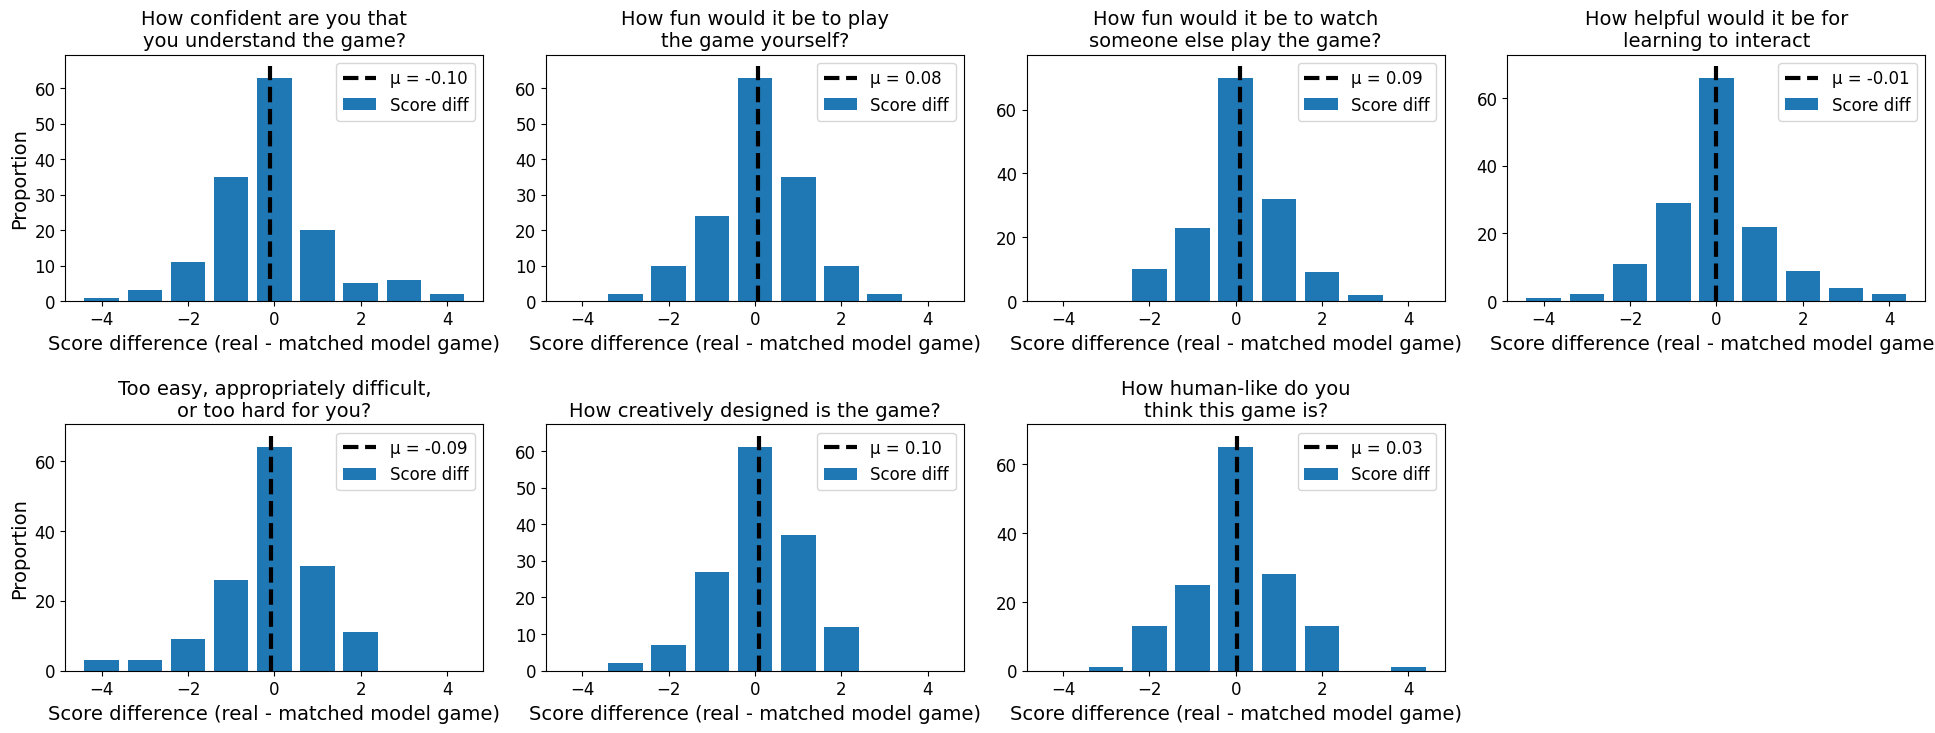

In [10]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'prolific_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'{attribute}_real'] - real_matched_df[f'{attribute}_matched']
    attribute_diff_counts = attribute_diffs.value_counts()
    ax.bar(x_values, [attribute_diff_counts.get(x, 0) for x in x_values], label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



## Run some matched-pairs t-tests

In [11]:
real_matched_df = current_participants_df[current_participants_df.game_type == 'real'].merge(
    current_participants_df[current_participants_df.game_type == 'matched'],
    on=['participant_id', 'prolific_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

confident:
	t-statistic = -0.8883588148845694
	p-value = 0.37581906336876514 

fun_play:
	t-statistic = 0.830638478261324
	p-value = 0.4075434986655846 

fun_watch:
	t-statistic = 1.0654947813221733
	p-value = 0.28842307599907174 

capability:
	t-statistic = -0.06528839556196349
	p-value = 0.9480343087951091 

goldilocks:
	t-statistic = -0.8943432533154099
	p-value = 0.372620359798428 

creativity:
	t-statistic = 1.1147050422576803
	p-value = 0.26682101538160885 

human_likeness:
	t-statistic = 0.2955715727224061
	p-value = 0.7679801247815303 



## And some unmatched t-tests between the unmatched games and other ones

In [12]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    for first, second in combinations(current_participants_df.game_type.cat.categories, 2):
        first_data = current_participants_df[current_participants_df.game_type == first][attribute]
        second_data = current_participants_df[current_participants_df.game_type == second][attribute]
        result = stats.ttest_ind(first_data, second_data)
        stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
        print(f'{tab}{first} (\u03bc = {first_data.mean():.2f}) vs {second} (\u03bc = {second_data.mean():.2f})')
        print(f'{tab}{tab}t-statistic = {result.statistic:.3f}')
        print(f'{tab}{tab}tp-value    = {result.pvalue:.3e} {stars}')

    print()

    

confident:
    real (μ = 3.80) vs matched (μ = 3.89)
        t-statistic = -0.637
        tp-value    = 5.246e-01 
    real (μ = 3.80) vs unmatched (μ = 3.16)
        t-statistic = 4.539
        tp-value    = 7.863e-06 ***
    matched (μ = 3.89) vs unmatched (μ = 3.16)
        t-statistic = 5.185
        tp-value    = 3.703e-07 ***

fun_play:
    real (μ = 2.42) vs matched (μ = 2.36)
        t-statistic = 0.527
        tp-value    = 5.986e-01 
    real (μ = 2.42) vs unmatched (μ = 1.96)
        t-statistic = 4.275
        tp-value    = 2.491e-05 ***
    matched (μ = 2.36) vs unmatched (μ = 1.96)
        t-statistic = 3.697
        tp-value    = 2.539e-04 ***

fun_watch:
    real (μ = 2.36) vs matched (μ = 2.29)
        t-statistic = 0.553
        tp-value    = 5.806e-01 
    real (μ = 2.36) vs unmatched (μ = 2.04)
        t-statistic = 2.860
        tp-value    = 4.494e-03 **
    matched (μ = 2.29) vs unmatched (μ = 2.04)
        t-statistic = 2.209
        tp-value    = 2.785e-02 *

c

## Trying to compute some inter-annotator agreement data

In [13]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    pivot_table = pd.pivot_table(current_participants_df, values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 = {alpha:.3f}')
    pivot_table_real_matched_only = pd.pivot_table(current_participants_df[current_participants_df.game_type != 'unmatched'], values=attribute, index='participant_id', columns='full_game_id')
    alpha = krippendorff.alpha(pivot_table_real_matched_only.values, level_of_measurement='ordinal')
    print(f'{tab}\u03b1 (real and matched only) = {alpha:.3f}')

    print()




confident:
    α = 0.300
    α (real and matched only) = 0.289

fun_play:
    α = 0.094
    α (real and matched only) = 0.023

fun_watch:
    α = 0.032
    α (real and matched only) = -0.026

capability:
    α = -0.045
    α (real and matched only) = -0.005

goldilocks:
    α = 0.166
    α (real and matched only) = 0.159

creativity:
    α = 0.161
    α (real and matched only) = 0.165

human_likeness:
    α = 0.129
    α (real and matched only) = 0.076



# Repeating some analyses with normalized scores
Normalizing within each (participant X question)

In [14]:
current_participants_normalized_df = current_participants_df.copy()

participant_ids = current_participants_df.participant_id.unique()

for participant_id in participant_ids:
    for attribute in NUMBER_SCORE_ATTRIBUTES:
        attribute_mean = current_participants_normalized_df[current_participants_normalized_df.participant_id == participant_id][attribute].mean()
        attribute_std = current_participants_normalized_df[current_participants_normalized_df.participant_id == participant_id][attribute].std()

        if attribute_std == 0:
            current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] = 0
        else:
            current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] = (current_participants_normalized_df.loc[current_participants_normalized_df.participant_id == participant_id, attribute] - attribute_mean) / attribute_std


current_participants_normalized_df.head()
    

,participant_id,prolific_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,0.239681,0.511166,0.511166,1.367198,-0.176166,0.000000,-0.948683,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched"
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,0.239681,0.511166,0.511166,0.607644,-0.176166,1.224745,-0.948683,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched"
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,0.239681,-0.340777,-0.340777,1.367198,0.704664,1.224745,-0.948683,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,1.038616,1.363108,1.363108,-0.151911,-1.056996,0.000000,-0.948683,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched"
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,-2.157126,-1.192720,-1.192720,-1.671020,1.585495,-1.224745,0.948683,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched"


## Histogram of the values per question

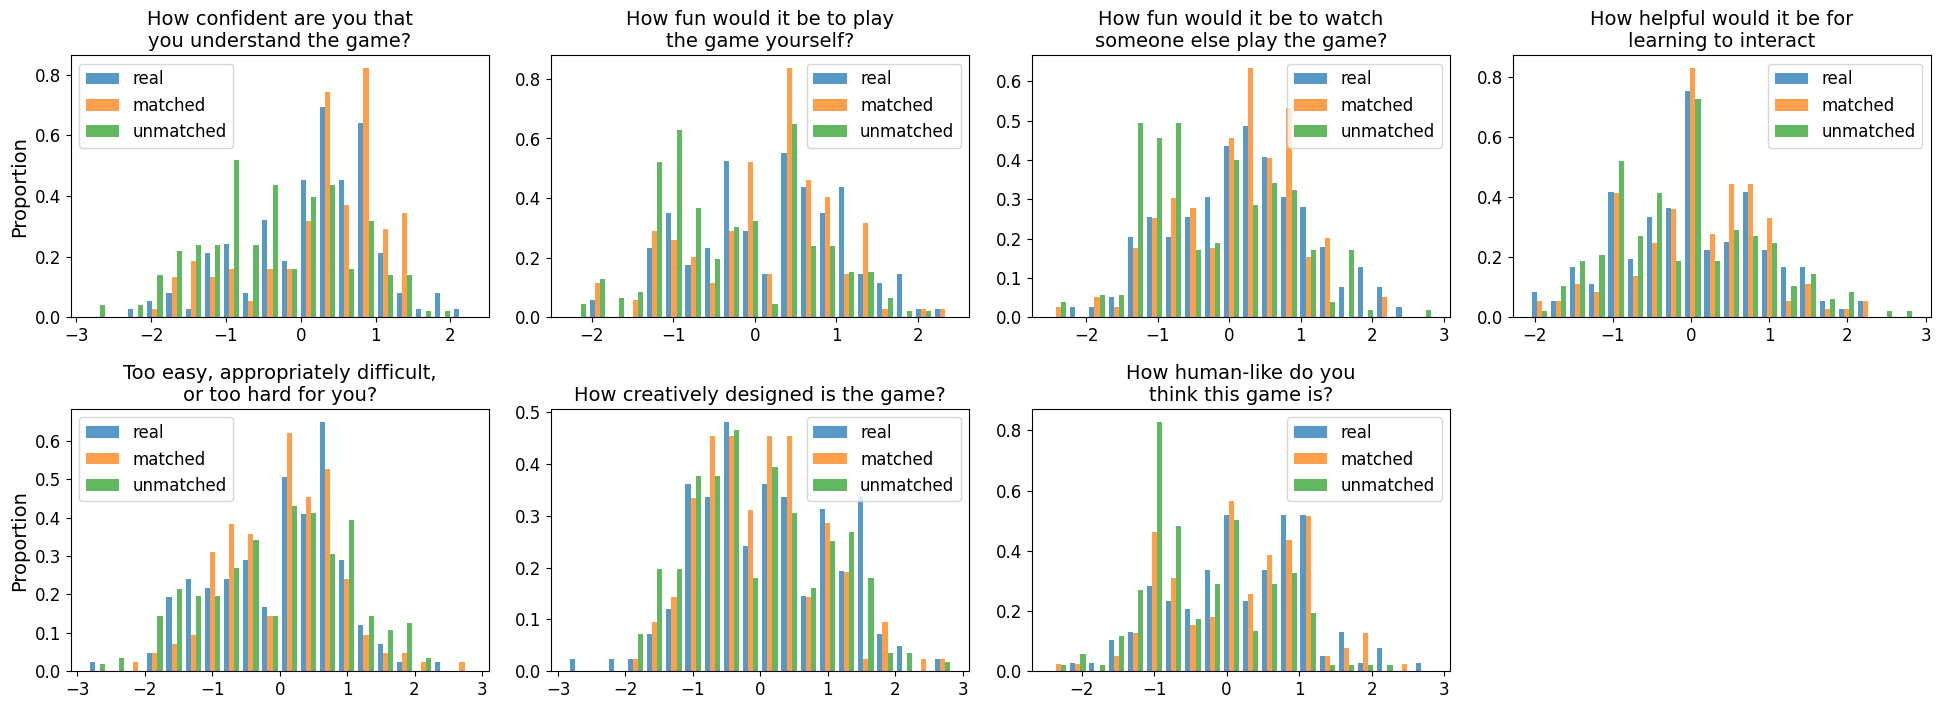

In [15]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
SEPARATE_PLOTS = False
N_BINS = 20

if not SEPARATE_PLOTS:
    fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    axes = list(chain.from_iterable(axes))


x = np.arange(5) + 1
width = 0.25
multiplier = 0

for i, attribute in enumerate(NUMBER_SCORE_ATTRIBUTES):
    if SEPARATE_PLOTS:
        fig, ax = plt.subplots(figsize=(PANEL_WIDTH, PANEL_HEIGHT))
    
    else:
        ax = axes[i]

    histotgram_data = [current_participants_normalized_df[current_participants_normalized_df.game_type == game_type][attribute] for game_type in current_participants_df.game_type.cat.categories]
    ax.hist(histotgram_data, bins=N_BINS, label=current_participants_df.game_type.cat.categories, alpha=0.75, density=True)

    # for game_type in current_participants_df.game_type.cat.categories:
        # offset = width * multiplier
        # normalized_value_counts = game_type_groupby.get_group(game_type)[attribute].value_counts().sort_index() / game_type_value_counts[game_type]
        
        
        # ax.bar(x + offset, normalized_value_counts, width=width, label=game_type)
        # multiplier += 1

    ax.set_xlabel('')

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)

    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)

    if SEPARATE_PLOTS:
        plt.show()

if not SEPARATE_PLOTS:
    # clear the 8th axis
    axes[-1].axis('off')
    plt.show()


In [16]:
tab = '    '

for attribute in NUMBER_SCORE_ATTRIBUTES:
    print(f'{attribute}:') 
    for first, second in combinations(current_participants_normalized_df.game_type.cat.categories, 2):
        first_data = current_participants_normalized_df[current_participants_normalized_df.game_type == first][attribute]
        second_data = current_participants_normalized_df[current_participants_normalized_df.game_type == second][attribute]
        result = stats.ttest_ind(first_data, second_data)
        stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
        print(f'{tab}{first} (\u03bc = {first_data.mean():.2f}) vs {second} (\u03bc = {second_data.mean():.2f})')
        print(f'{tab}{tab}t-statistic = {result.statistic:.3f}')
        print(f'{tab}{tab}tp-value    = {result.pvalue:.3e} {stars}')

    print()

    

confident:
    real (μ = 0.18) vs matched (μ = 0.27)
        t-statistic = -0.950
        tp-value    = 3.430e-01 
    real (μ = 0.18) vs unmatched (μ = -0.34)
        t-statistic = 5.150
        tp-value    = 4.414e-07 ***
    matched (μ = 0.27) vs unmatched (μ = -0.34)
        t-statistic = 6.086
        tp-value    = 3.122e-09 ***

fun_play:
    real (μ = 0.22) vs matched (μ = 0.14)
        t-statistic = 0.795
        tp-value    = 4.270e-01 
    real (μ = 0.22) vs unmatched (μ = -0.27)
        t-statistic = 4.803
        tp-value    = 2.346e-06 ***
    matched (μ = 0.14) vs unmatched (μ = -0.27)
        t-statistic = 4.053
        tp-value    = 6.260e-05 ***

fun_watch:
    real (μ = 0.20) vs matched (μ = 0.08)
        t-statistic = 1.133
        tp-value    = 2.582e-01 
    real (μ = 0.20) vs unmatched (μ = -0.21)
        t-statistic = 3.898
        tp-value    = 1.171e-04 ***
    matched (μ = 0.08) vs unmatched (μ = -0.21)
        t-statistic = 2.903
        tp-value    = 3.931e-

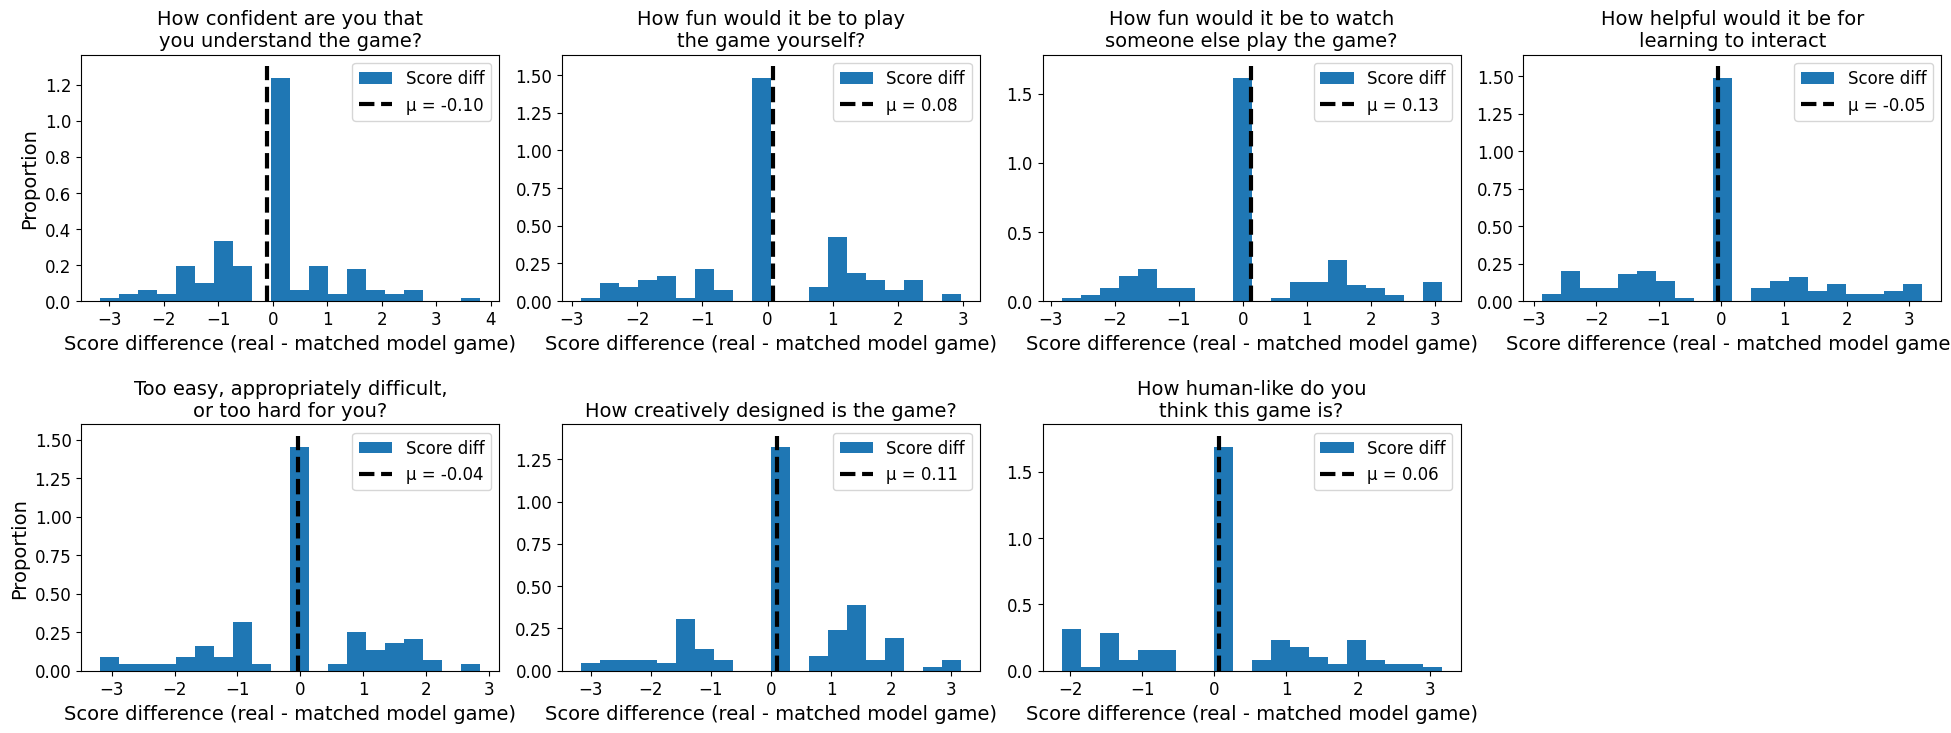

In [17]:
PANEL_HEIGHT = 4
PANEL_WIDTH = 6
NROWS = 2
NCOLS = 4
START_XLABELS_INDEX = 3
LEGEND_AX = 4
FONTDICT = dict(fontsize=14)
N_BINS = 20

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(PANEL_WIDTH * NCOLS, PANEL_HEIGHT * NROWS))
plt.subplots_adjust(hspace=0.5, wspace=0.15)

real_matched_df = current_participants_normalized_df[current_participants_normalized_df.game_type == 'real'].merge(
    current_participants_normalized_df[current_participants_normalized_df.game_type == 'matched'],
    on=['participant_id', 'prolific_id', 'game_id'],
    suffixes=('_real', '_matched')
)

x_values = np.arange(-4, 5)

for i, (attribute, ax) in enumerate(zip(NUMBER_SCORE_ATTRIBUTES, chain.from_iterable(axes))):
    attribute_diffs = real_matched_df[f'{attribute}_real'] - real_matched_df[f'{attribute}_matched']
    # attribute_diff_counts = attribute_diffs.value_counts()
    ax.hist(attribute_diffs, bins=N_BINS, density=True, label='Score diff')
    ax.vlines(attribute_diffs.mean(), 0, ax.get_ylim()[1], color='black', label=f'\u03bc = {attribute_diffs.mean():.2f}', ls='--', lw=3)

    ax.set_xlabel('Score difference (real - matched model game)', fontdict=FONTDICT)

    if i % NCOLS == 0:
        ax.set_ylabel('Proportion', fontdict=FONTDICT)

    # if i == LEGEND_AX:
    ax.legend(loc='best', fontsize=FONTDICT['fontsize'] - 2)
    ax.set_title(add_linebreaks(NUMBER_SCORE_AXIS_NAMES[attribute]), fontdict=FONTDICT)
    ax.tick_params(axis='both', which='major', labelsize=FONTDICT['fontsize'] - 2)


# clear the 8th axis
axes[-1][-1].axis('off')
plt.show()



In [18]:
real_matched_df = current_participants_normalized_df[current_participants_normalized_df.game_type == 'real'].merge(
    current_participants_normalized_df[current_participants_normalized_df.game_type == 'matched'],
    on=['participant_id', 'prolific_id', 'game_id'],
    suffixes=('_real', '_matched')
)


for attribute in NUMBER_SCORE_ATTRIBUTES:
    result = stats.ttest_rel(real_matched_df[f'{attribute}_real'], real_matched_df[f'{attribute}_matched'])
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{attribute}:') 
    print(f'\tt-statistic = {result.statistic}')
    print(f'\tp-value = {result.pvalue} {stars}')
    print()
    

confident:
	t-statistic = -1.1199234582666413
	p-value = 0.2645979912205394 

fun_play:
	t-statistic = 0.82919801253659
	p-value = 0.40835531167337724 

fun_watch:
	t-statistic = 1.2031789766210523
	p-value = 0.23086786092845507 

capability:
	t-statistic = -0.4278915231561957
	p-value = 0.6693649435139319 

goldilocks:
	t-statistic = -0.35099014616815244
	p-value = 0.7261051826171538 

creativity:
	t-statistic = 1.0162831205475973
	p-value = 0.31118733676429794 

human_likeness:
	t-statistic = 0.6140821641514325
	p-value = 0.5401233027656016 



# Trying to run some mixed effects models

In [85]:
current_participants_normalized_df = current_participants_normalized_df.assign(
    game_type_real=pd.Series(current_participants_normalized_df.game_type == 'real', dtype=int),
    game_type_matched=pd.Series(current_participants_normalized_df.game_type == 'matched', dtype=int),
    game_type_unmatched=pd.Series(current_participants_normalized_df.game_type == 'unmatched', dtype=int),
    game_type=current_participants_normalized_df.game_type.cat.reorder_categories(['unmatched', 'matched', 'real']),
)

current_participants_normalized_df.head()

,participant_id,prolific_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,human_likeness,explain,overall,game_type,full_game_id,game_type_real,game_type_matched,game_type_unmatched
0,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",False,False,0.239681,0.511166,0.511166,1.367198,-0.176166,0.000000,-0.948683,"The game is composed of two components. First,...",The instructions seem to be pretty straightfor...,unmatched,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched",0,0,1
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",False,False,0.239681,0.511166,0.511166,0.607644,-0.176166,1.224745,-0.948683,"First, you need to place the hexagon bin near ...",This games seems slightly more difficult that ...,unmatched,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)-unmatched",0,0,1
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",True,True,0.239681,-0.340777,-0.340777,1.367198,0.704664,1.224745,-0.948683,"First, you need to put the bin next to the bed...",This game is more challenging than the prior t...,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real",1,0,0
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",False,True,1.038616,1.363108,1.363108,-0.151911,-1.056996,0.000000,-0.948683,Place the bin next to the wall. Throw balls t...,This game has the simplest instructions. One c...,matched,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-matched",0,1,0
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,5ef4d8b87faaa00c0dea0c4e,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)",False,False,-2.157126,-1.192720,-1.192720,-1.671020,1.585495,-1.224745,0.948683,Move chairs and then let them go so they end u...,I don't like this game. I don't really unders...,unmatched,"(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)-unmatched",0,0,1


In [121]:
# vc = {'participant_id': '0 + C(participant_id)'}
# md = smf.mixedlm('confident ~ game_type', current_participants_normalized_df, groups='game_type', vc_formula=vc)
# mdf = md.fit()

vc = {'full_game_id': '0 + C(full_game_id)'}
for attribute in NUMBER_SCORE_ATTRIBUTES:
    display(Markdown(f'### {attribute}:'))
    md = smf.mixedlm(f'{attribute} ~ game_type + 1', current_participants_normalized_df, groups='participant_id', vc_formula=vc)
    mdf = md.fit()
    display(mdf.summary())
    display(Markdown('-----------'))




### confident:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   confident
No. Observations:     489       Method:               REML     
No. Groups:           49        Scale:                0.4043   
Min. group size:      9         Log-Likelihood:       -645.6141
Max. group size:      10        Converged:            Yes      
Mean group size:      10.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.338    0.064 -5.261 0.000 -0.464 -0.212
game_type[T.matched]  0.611    0.098  6.228 0.000  0.419  0.803
game_type[T.real]     0.517    0.098  5.254 0.000  0.324  0.709
full_game_id Var      0.404                                    
===============================================================

"""

-----------

### fun_play:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM   Dependent Variable:   fun_play 
No. Observations:     489       Method:               REML     
No. Groups:           49        Scale:                0.4099   
Min. group size:      9         Log-Likelihood:       -648.9510
Max. group size:      10        Converged:            Yes      
Mean group size:      10.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.266    0.065 -4.107 0.000 -0.392 -0.139
game_type[T.matched]  0.403    0.099  4.075 0.000  0.209  0.596
game_type[T.real]     0.484    0.099  4.893 0.000  0.290  0.678
full_game_id Var      0.410                                    
===============================================================

"""

-----------

### fun_watch:

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                 MixedLM    Dependent Variable:    fun_watch
No. Observations:      489        Method:                REML     
No. Groups:            49         Scale:                 0.4188   
Min. group size:       9          Log-Likelihood:        -654.1401
Max. group size:       10         Converged:             Yes      
Mean group size:       10.0                                       
------------------------------------------------------------------
                     Coef.    Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept            -0.207       0.065 -3.160 0.002 -0.335 -0.078
game_type[T.matched]  0.286       0.100  2.864 0.004  0.090  0.482
game_type[T.real]     0.404       0.100  4.037 0.000  0.208  0.600
full_game_id Var      0.419 5439000.275                           
==================================================================

"""

-----------

### capability:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   capability
No. Observations:    489       Method:               REML      
No. Groups:          49        Scale:                0.4048    
Min. group size:     9         Log-Likelihood:       -645.8804 
Max. group size:     10        Converged:            Yes       
Mean group size:     10.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.065    0.064 -1.013 0.311 -0.191  0.061
game_type[T.matched]  0.134    0.098  1.364 0.173 -0.058  0.326
game_type[T.real]     0.083    0.098  0.845 0.398 -0.110  0.276
full_game_id Var      0.405                                    
===============================================================

"""

-----------

### goldilocks:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   goldilocks
No. Observations:    489       Method:               REML      
No. Groups:          49        Scale:                0.4339    
Min. group size:     9         Log-Likelihood:       -662.7946 
Max. group size:     10        Converged:            Yes       
Mean group size:     10.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.021    0.067 -0.310 0.757 -0.151  0.110
game_type[T.matched]  0.050    0.102  0.495 0.620 -0.149  0.250
game_type[T.real]     0.018    0.102  0.180 0.857 -0.181  0.218
full_game_id Var      0.434                                    
===============================================================

"""

-----------

### creativity:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   creativity
No. Observations:    489       Method:               REML      
No. Groups:          49        Scale:                0.4501    
Min. group size:     9         Log-Likelihood:       -671.7077 
Max. group size:     10        Converged:            Yes       
Mean group size:     10.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.066    0.068 -0.976 0.329 -0.199  0.067
game_type[T.matched]  0.051    0.104  0.497 0.619 -0.151  0.254
game_type[T.real]     0.170    0.104  1.636 0.102 -0.034  0.373
full_game_id Var      0.450                                    
===============================================================

"""

-----------

### human_likeness:

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:             MixedLM  Dependent Variable:  human_likeness
No. Observations:  489      Method:              REML          
No. Groups:        49       Scale:               0.4030        
Min. group size:   9        Log-Likelihood:      -644.8270     
Max. group size:   10       Converged:           Yes           
Mean group size:   10.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.303    0.064 -4.725 0.000 -0.429 -0.177
game_type[T.matched]  0.477    0.098  4.865 0.000  0.285  0.669
game_type[T.real]     0.535    0.098  5.450 0.000  0.343  0.727
full_game_id Var      0.403                                    
===============================================================

"""

-----------

ValueError: endog has evaluated to an array with multiple columns that has shape (489, 5). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).